#Project# 1

# Inference Pipeline for Face Recognition Systems
- For detection of faces we will use MTCNN
- For the alignment, to maintain the simplicity of the scope of this kernel we will only use 2D alignment
- We will then use our model to extract the features

<img src='https://www.researchgate.net/publication/282863610/figure/fig1/AS:669508570214408@1536634690438/Processing-pipeline-of-face-recognition.jpg'>



*   *Develop a Face Recognition System Using 
FaceNet for your classmate*
* **[3 pt]**   Collect a dataset for you and your classmate to do your system
 
* **[2 pt]** Do a Face_Verification function that verifies that the two images for the same person
  * The function Input is the path of two images. 
  * It checks whether both images belong to the same person.
  * It returns "same Person" or "not same person" and the distance between them
  * recognition = Face_Verification("./image1.jpg",  "./image2.jpg")
* **[5 pt]**  Do a **Face_Recognition** A function that clusters an Image to a specific folder in a labeled database 
  * The function Input is the image and folder path. 
  * It returns a dictionary of the nearest label folders to the input image and its distance.
  * recognition = Face_Recognition("./test_image.jpg",  "./labeld_database")
 
---
**you may use these steps**

* Read an image and Detect the face
*  perform alignment
* Extract face embeddings
* Calculate the distance between embeddings present in the database and extracted input face embeddings
*  Find the index of the lowest distance, and check if the distance is less than a threshold
  * If yes then use the index to find the person from the database
  * Else the person in the input image is not present in the database
*  Use the OpenCV utilities to tag the person in the image
* cluster faces using SVM 
* visualize each step

In [ ]:
!pip install keras-facenet
!pip install mtcnn
!pip install opencv-python
!pip install mtcnn
!pip install keras_vggface

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import math 
import cv2
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import mtcnn
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from os import listdir
from os.path import join
import os
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
from google.colab import drive
from mtcnn import MTCNN
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

drive.mount('/content/drive')
%cd /content/drive/MyDrive/UNI/img_dataset/

embedder = FaceNet()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UNI/img_dataset


In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

def Face_Verification(image1_path, image2_path):
  # load image from file
  image = Image.open(image1_path)
  plt.imshow(image)
  plt.show()
  # load image from file
  image = Image.open(image2_path)
  plt.imshow(image)
  plt.show()
  detect_ii = embedder.extract(image1_path, threshold=0.95)
  detect_jj = embedder.extract(image2_path, threshold=0.95)
  dd = embedder.compute_distance(detect_ii[0]['embedding'], detect_jj[0]['embedding'])
  if dd<.5:
    recognition = 'Same Person'
  else:
    recognition = 'NOT The Same Person'
  return recognition, dd

def Face_Recognition(img_path, dir):
    detect_ii = embedder.extract(img_path, threshold=0.95)
    recog_dic = {}
    for subdir in os.listdir(dir):
        max = np.inf
        path = dir + subdir + '/'
        for photo in range(len((os.listdir(path)))):
            image2_path = path + os.listdir(path)[photo]
            detect_jj = embedder.extract(image2_path, threshold=0.95)
            dist = embedder.compute_distance(detect_ii[0]['embedding'], detect_jj[0]['embedding'])
            if dist < max:
                max = dist
        recog_dic[subdir] = max
    print('Predicted:'+ list(recog_dic.keys())[list(recog_dic.values()).index(min(recog_dic.values()))])
    return recog_dic

In [ ]:
%ls

test/  train/


In [ ]:
# load train dataset
trainX, trainy = load_dataset('./train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./test/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('dataset.npz', trainX, trainy, testX, testy)

# load the face dataset
data = np.load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# get the face embedding for one face
facenet_model=embedder.model

# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('dataset-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 191ms/step
loaded 5 sample for class: Jacques_Chirac
1/1 [==============================] - 0s 151ms/step
loaded 5 sample for class: Tony_Blair
1/1 [==============================] - 0s 229ms/step
loaded 5 sample for class: Amr Elmasry
1/1 [==============================] - 0s 136ms/step
loaded 5 sample for class: Vladimir_Putin
1/1 [==============================] - 0s 331ms/step
loaded 5 sample for class: Hugo_Chavez
1/1 [==============================] - 0s 155ms/step
loaded 5 sample for class: George_W_Bush
1/1 [==============================] - 0s 255ms/step
loaded 5 sample for class: Donald_Rumsfeld
1/1 [==============================] - 0s 133ms/step
loaded 5 sample for class: Gerhard_Schroeder
1/1 [==============================] - 0s 138ms/step
loaded 5 sample for class: Colin_Powell
1/1 [==============================] - 0s 199ms/step
loaded 5 sample for class: Ahmed Helmy
1/1 [==============================] - 1s 788ms/step
loaded 5 

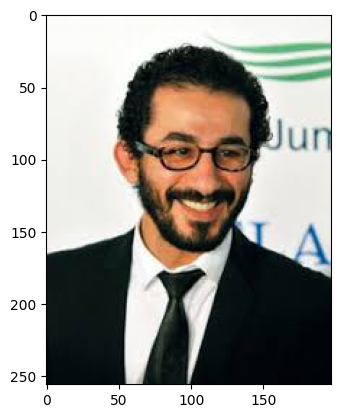

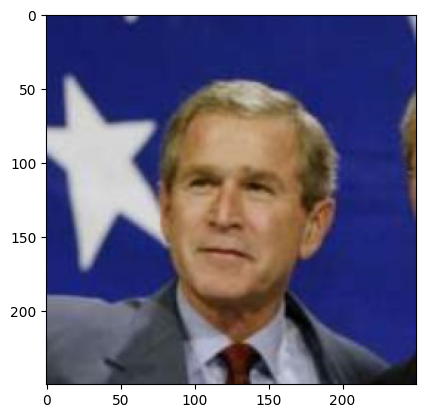

1/1 [==============================] - 0s 86ms/step
Verification: NOT The Same Person with  a distance of: 1.0696967914700508


In [ ]:
img1_path = './test/Ahmed Helmy/Ahmed_Helmy032.jpg'
img2_path = './test/George_W_Bush/George_W_Bush_0001.jpg'

verification,distance = Face_Verification(img1_path, img2_path)
print ("Verification: "+ verification + " with  a distance of: " + str(distance))

In [ ]:
Face_Recognition(img1_path, './test/')

1/1 [==============================] - 0s 87ms/step
Predicted:Ahmed Helmy


{'Ahmed Helmy': 0,
 'Vladimir_Putin': 0.9599426500499249,
 'Tony_Blair': 1.0647957250475883,
 'Jacques_Chirac': 0.954516738653183,
 'Hugo_Chavez': 0.8960568383336067,
 'Gerhard_Schroeder': 1.1762578934431076,
 'George_W_Bush': 1.0245895348489285,
 'Donald_Rumsfeld': 0.9830467272549868,
 'Colin_Powell': 0.9280925542116165,
 'Amr Elmasry': 0.9294600859284401,
 'AL-Limby': 0.682293713092804}

In [ ]:
model.load_weights('model.h5')